# Stage 2: Single-Bounce NLOS Classifier
## Multi-Model Pipeline — Bounce Type Detection

**Purpose**: Given an NLOS signal (classified by Stage 1), determine if it is a **single-bounce** or **multi-bounce** reflection.

**Why this matters**: Single-bounce NLOS has predictable geometry (direct path → wall → receiver), so the extra distance can be estimated and corrected in Stage 3. Multi-bounce NLOS has chaotic reflections that can't be geometrically modeled.

**Features**: 6 physics features derived entirely from the CIR waveform — no hardware-specific registers (FP_AMPL1/2/3).

**Labels**: Auto-derived from CIR peak analysis (no manual labels exist in the dataset).

**Architecture**: Random Forest — physics features are tabular, small dataset (~1800 NLOS samples). Tree-based ensembles excel here without the overfitting risk of neural networks.

**Pipeline**: Stage 1 (LNN → LOS/NLOS) → **Stage 2 (RF → single/multi bounce)** → Stage 3 (distance correction)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import kurtosis as scipy_kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
import joblib
import os

# ==========================================
# CONFIGURATION
# ==========================================
CONFIG = {
    # ROI alignment (same as Stage 1)
    "search_start": 740,
    "search_end": 890,
    # Peak detection
    "peak_prominence": 0.20,
    "peak_min_distance": 5,
    # Auto-label threshold
    "single_bounce_max_peaks": 2,
    # Random Forest
    "n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    # Split
    "test_ratio": 0.30,
    "seed": 42,
}

# Num_Peaks excluded: it IS the auto-label source (Num_Peaks > 2 = multi-bounce).
# Including it would be data leakage — the model would learn the labeling rule, not physics.
# These 5 features describe the CIR SHAPE without counting peaks.
FEATURE_NAMES = [
    "Kurtosis", "Rise_Time", "RMS_Delay_Spread",
    "Mean_Excess_Delay", "Power_Ratio"
]

np.random.seed(CONFIG["seed"])
print(f"Config: {CONFIG}")
print(f"Features ({len(FEATURE_NAMES)}): {FEATURE_NAMES}")
print(f"Note: Num_Peaks excluded (used for auto-labeling, not as model input)")

Config: {'search_start': 740, 'search_end': 890, 'peak_prominence': 0.2, 'peak_min_distance': 5, 'single_bounce_max_peaks': 2, 'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'test_ratio': 0.3, 'seed': 42}
Features (5): ['Kurtosis', 'Rise_Time', 'RMS_Delay_Spread', 'Mean_Excess_Delay', 'Power_Ratio']
Note: Num_Peaks excluded (used for auto-labeling, not as model input)


---
## Section 2: Data Loading & CIR Feature Extraction

Load NLOS samples from the training dataset, then compute 6 physics features **entirely from the CIR waveform**.

The leading edge is estimated from the CIR using the same ROI alignment as Stage 1 — no hardware FP_INDEX register needed.

| Feature | Physical Meaning |
|---------|------------------|
| Kurtosis | Pulse sharpness — high = concentrated (single-bounce), low = spread (multi-bounce) |
| Rise_Time | Samples from leading edge to peak — fast = fewer reflections |
| RMS_Delay_Spread | Temporal spread of multipath energy — key bounce discriminator |
| Mean_Excess_Delay | Average delay of reflected energy beyond first path |
| Power_Ratio | Fraction of energy in first-path window vs total |
| Num_Peaks | Direct count of resolved multipath components |

In [3]:
# ==========================================
# ROI ALIGNMENT (reused from Stage 1)
# ==========================================
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    """Find leading edge by backtracking from peak."""
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    
    return leading_edge


# ==========================================
# CIR FEATURE EXTRACTION
# ==========================================
def extract_cir_features(sig, leading_edge, config=CONFIG):
    """
    Extract 6 physics features from RXPACC-normalized CIR.
    All derived from the CIR waveform + estimated leading edge.
    """
    peak_idx = np.argmax(sig[config["search_start"]:config["search_end"]]) + config["search_start"]
    peak_val = sig[peak_idx]
    
    # 1. Kurtosis — sharpness of pulse around peak
    win_start = max(0, peak_idx - 10)
    win_end = min(len(sig), peak_idx + 30)
    window = sig[win_start:win_end]
    kurt = scipy_kurtosis(window, fisher=True) if len(window) > 4 else 0.0
    
    # 2. Rise Time — samples from leading edge to peak
    rise_time = float(peak_idx - leading_edge)
    
    # 3 & 4. PDP-based: Mean Excess Delay & RMS Delay Spread
    pdp_start = max(0, leading_edge)
    pdp_sig = sig[pdp_start:min(pdp_start + 150, len(sig))]
    pdp = pdp_sig ** 2  # Power Delay Profile
    total_pdp = np.sum(pdp)
    
    if total_pdp > 0:
        times = np.arange(len(pdp), dtype=float)
        mean_delay = np.sum(pdp * times) / total_pdp
        second_moment = np.sum(pdp * times ** 2) / total_pdp
        rms_spread = np.sqrt(max(0, second_moment - mean_delay ** 2))
    else:
        mean_delay = 0.0
        rms_spread = 0.0
    
    # 5. Power Ratio — energy in first-path window / total energy
    fp_start = max(0, leading_edge - 1)
    fp_end = min(len(sig), leading_edge + 2)
    fp_energy = np.sum(sig[fp_start:fp_end] ** 2)
    total_energy = np.sum(sig ** 2)
    power_ratio = fp_energy / total_energy if total_energy > 0 else 0.0
    
    # 6. Number of Peaks — resolved multipath components
    roi_start = max(0, leading_edge - 5)
    roi_end = min(len(sig), leading_edge + 120)
    roi = sig[roi_start:roi_end]
    
    if len(roi) > 0 and np.max(roi) > 0:
        roi_norm = roi / np.max(roi)
        peaks, _ = find_peaks(
            roi_norm,
            prominence=config["peak_prominence"],
            distance=config["peak_min_distance"]
        )
        num_peaks = len(peaks)
    else:
        num_peaks = 0
    
    return {
        "Kurtosis": kurt,
        "Rise_Time": rise_time,
        "RMS_Delay_Spread": rms_spread,
        "Mean_Excess_Delay": mean_delay,
        "Power_Ratio": power_ratio,
        "Num_Peaks": float(num_peaks),
    }


# ==========================================
# LOAD NLOS DATA + EXTRACT FEATURES
# ==========================================
def load_nlos_features(filepath="../dataset/channels/combined_uwb_dataset.csv"):
    """Load NLOS samples and compute CIR-derived features."""
    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)
    
    # Filter NLOS only
    nlos_df = df[df["Label"] == 1].reset_index(drop=True)
    print(f"  Total samples: {len(df)}, NLOS samples: {len(nlos_df)}")
    
    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )
    
    features_list = []
    raw_sigs = []
    leading_edges = []
    
    for idx, row in nlos_df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        
        # RXPACC normalization
        rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
        if rxpacc > 0:
            sig = sig / rxpacc
        
        # Estimate leading edge from CIR
        le = get_roi_alignment(sig)
        
        # Extract features
        feats = extract_cir_features(sig, le)
        features_list.append(feats)
        raw_sigs.append(sig)
        leading_edges.append(le)
    
    feature_df = pd.DataFrame(features_list)
    print(f"  Features extracted: {list(feature_df.columns)}")
    print(f"  Feature stats:")
    print(feature_df.describe().round(2))
    
    return feature_df, np.array(raw_sigs), np.array(leading_edges), nlos_df


feature_df, raw_sigs, leading_edges, nlos_df = load_nlos_features()

Loading: ../dataset/channels/combined_uwb_dataset.csv
  Total samples: 3600, NLOS samples: 1800
  Features extracted: ['Kurtosis', 'Rise_Time', 'RMS_Delay_Spread', 'Mean_Excess_Delay', 'Power_Ratio', 'Num_Peaks']
  Feature stats:
       Kurtosis  Rise_Time  RMS_Delay_Spread  Mean_Excess_Delay  Power_Ratio  \
count   1800.00    1800.00           1800.00            1800.00      1800.00   
mean       2.38       5.46             25.68              19.16         0.06   
std        2.84       5.47              5.75               9.58         0.08   
min       -1.34       0.00             12.74               7.21         0.00   
25%       -0.37       2.00             20.61              10.82         0.01   
50%        2.23       4.00             26.60              14.75         0.02   
75%        4.79       7.00             30.32              28.40         0.07   
max        8.79      34.00             41.62              41.39         0.35   

       Num_Peaks  
count    1800.00  
mean       

---
## Section 3: Auto-Labeling (Deriving Ground Truth)

No single-bounce vs multi-bounce labels exist in the dataset. We derive them from the CIR physics:

- **Single-bounce** (label=0): `Num_Peaks <= 2` — one direct (attenuated) path + at most one reflection
- **Multi-bounce** (label=1): `Num_Peaks > 2` — multiple resolved reflection paths

Physical justification: Each significant peak in the CIR corresponds to a distinct multipath arrival.

Auto-labeling complete (threshold: Num_Peaks > 2)
  Single-bounce: 851 (47.3%)
  Multi-bounce:  949 (52.7%)


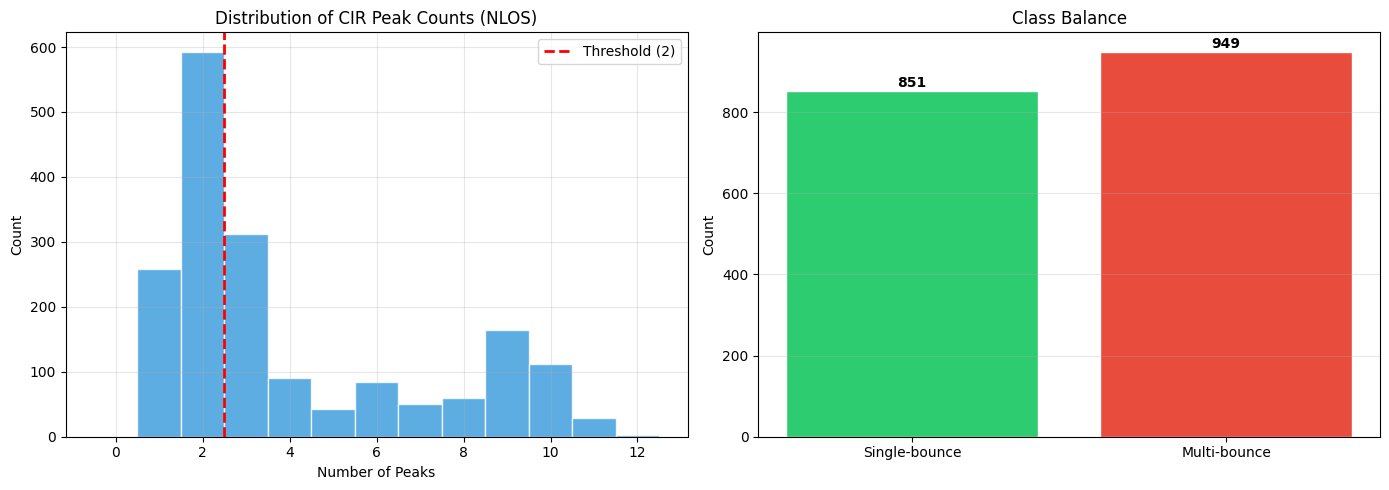

In [4]:
# ==========================================
# AUTO-LABELING FROM CIR PEAK COUNT
# ==========================================
threshold = CONFIG["single_bounce_max_peaks"]
bounce_labels = (feature_df["Num_Peaks"] > threshold).astype(int).values

n_single = int(np.sum(bounce_labels == 0))
n_multi = int(np.sum(bounce_labels == 1))
print(f"Auto-labeling complete (threshold: Num_Peaks > {threshold})")
print(f"  Single-bounce: {n_single} ({100*n_single/len(bounce_labels):.1f}%)")
print(f"  Multi-bounce:  {n_multi} ({100*n_multi/len(bounce_labels):.1f}%)")

# Histogram of peak counts
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

ax = axs[0]
peak_counts = feature_df["Num_Peaks"].values
ax.hist(peak_counts, bins=np.arange(0, peak_counts.max() + 2) - 0.5,
        color='#3498db', edgecolor='white', alpha=0.8)
ax.axvline(threshold + 0.5, color='red', ls='--', lw=2, label=f'Threshold ({threshold})')
ax.set_xlabel("Number of Peaks")
ax.set_ylabel("Count")
ax.set_title("Distribution of CIR Peak Counts (NLOS)")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axs[1]
colors = ['#2ecc71' if l == 0 else '#e74c3c' for l in bounce_labels]
ax.bar(["Single-bounce", "Multi-bounce"], [n_single, n_multi],
       color=['#2ecc71', '#e74c3c'], edgecolor='white')
ax.set_ylabel("Count")
ax.set_title("Class Balance")
for i, v in enumerate([n_single, n_multi]):
    ax.text(i, v + 10, str(v), ha='center', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## Section 4: Feature Analysis & Visualization

Validate that auto-labels and features are physically meaningful before training.

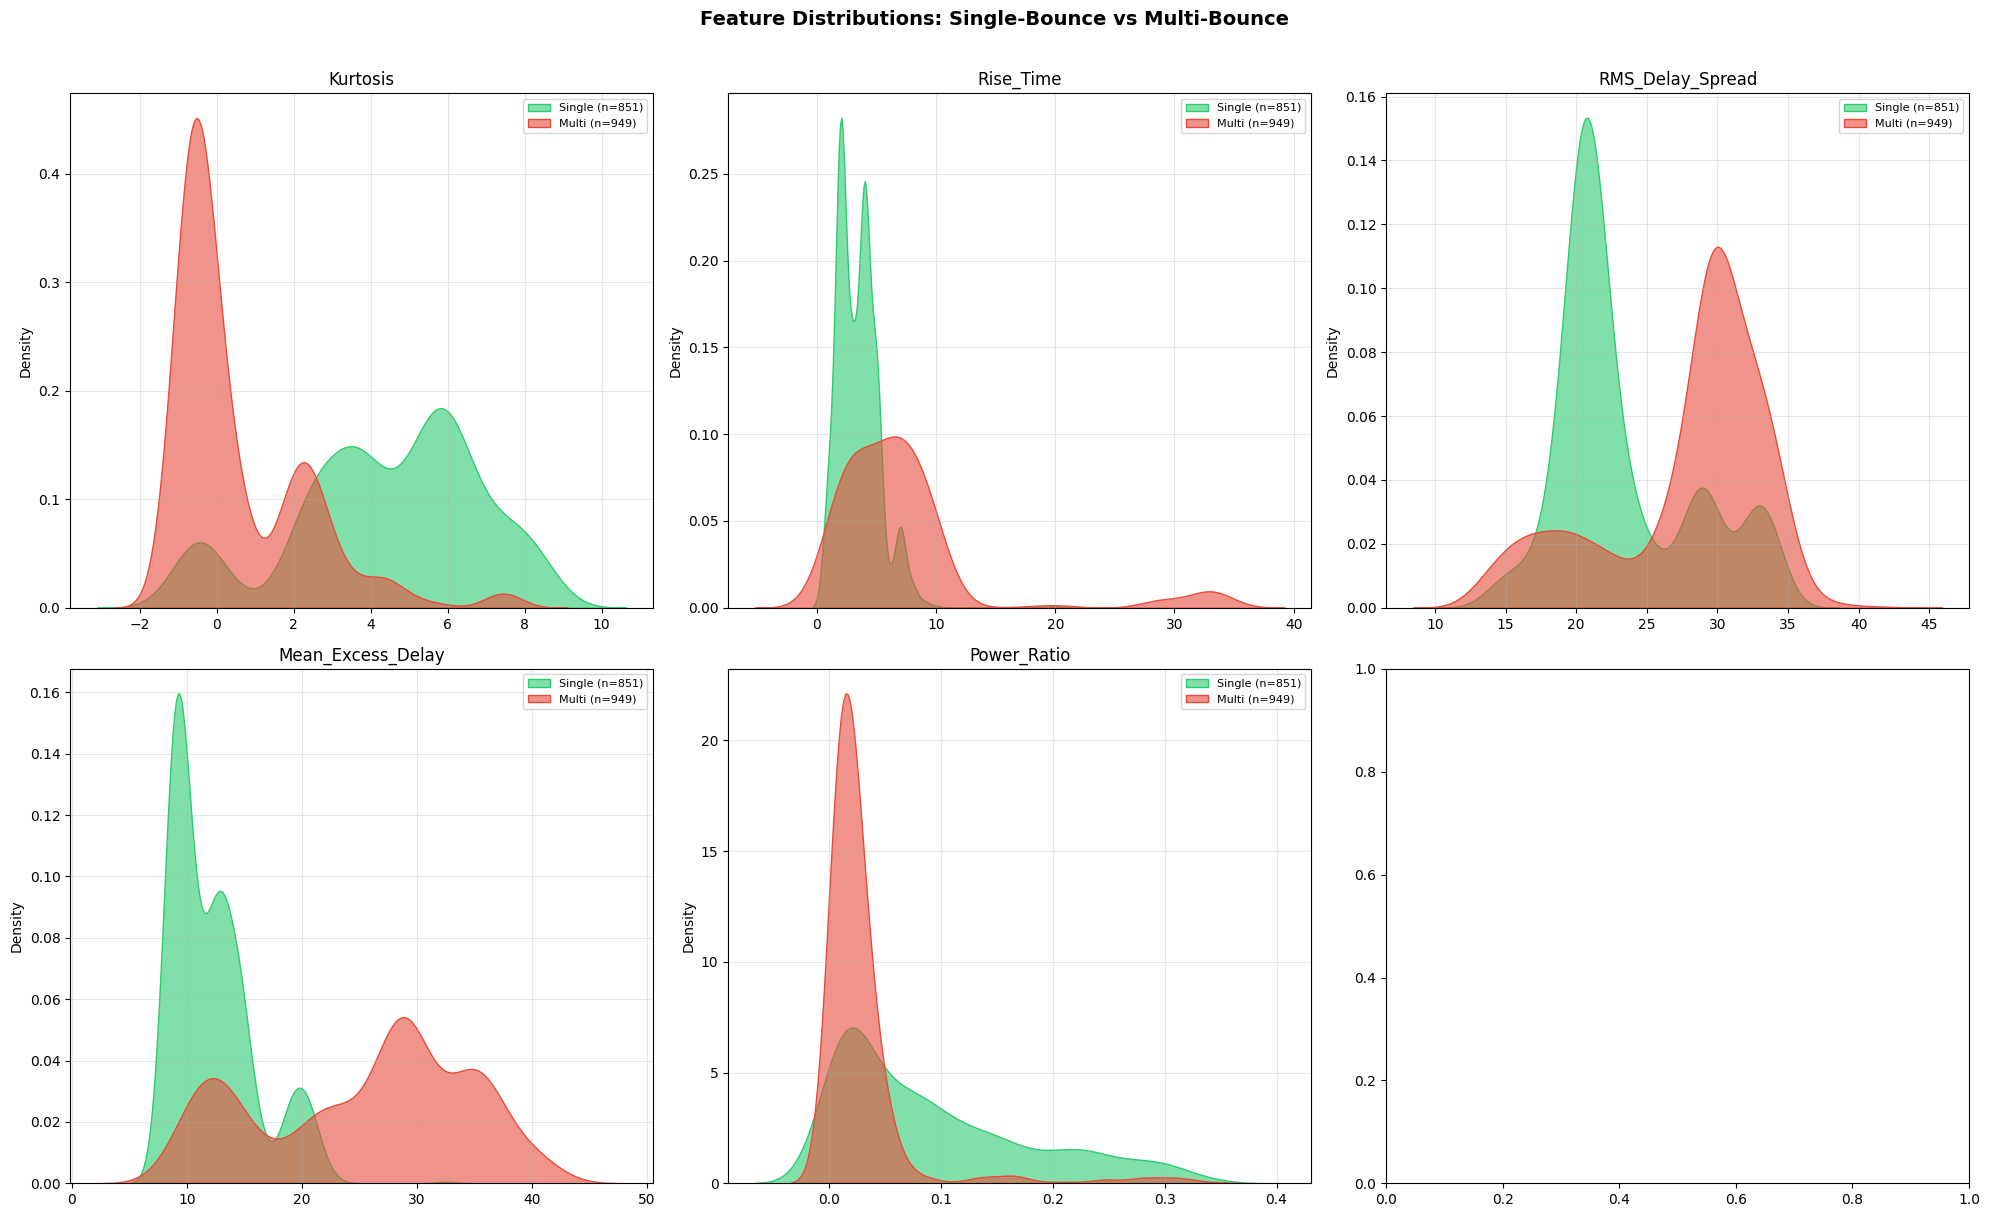

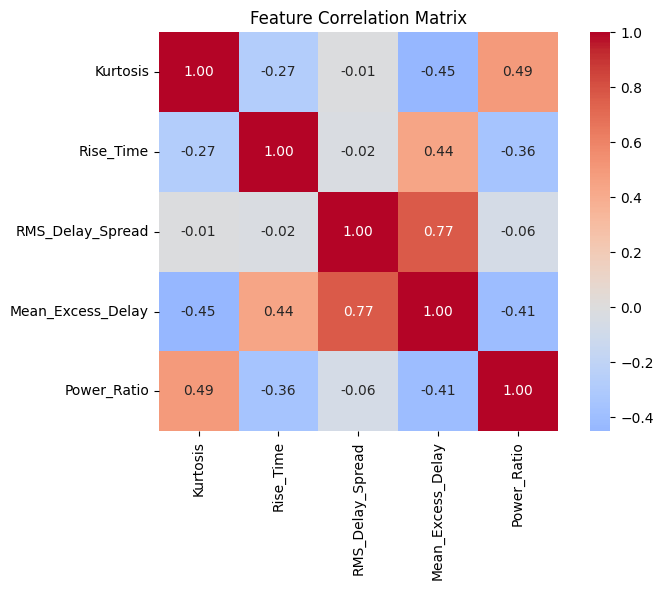


Fisher Discriminant Ratio (higher = more discriminative):
----------------------------------------
  Kurtosis                  1.7640
  Rise_Time                 0.2900
  RMS_Delay_Spread          0.3803
  Mean_Excess_Delay         1.8798
  Power_Ratio               0.4163

Best discriminator: Mean_Excess_Delay


In [5]:
# ==========================================
# FEATURE ANALYSIS
# ==========================================
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

single_mask = bounce_labels == 0
multi_mask = bounce_labels == 1

# --- Feature distributions by class ---
for i, feat in enumerate(FEATURE_NAMES):
    ax = axs[i // 3, i % 3]
    vals = feature_df[feat].values
    
    sns.kdeplot(vals[single_mask], ax=ax, fill=True, color='#2ecc71',
                label=f'Single (n={single_mask.sum()})', alpha=0.6)
    sns.kdeplot(vals[multi_mask], ax=ax, fill=True, color='#e74c3c',
                label=f'Multi (n={multi_mask.sum()})', alpha=0.6)
    
    ax.set_title(feat)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Feature Distributions: Single-Bounce vs Multi-Bounce",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# --- Correlation matrix ---
fig, ax = plt.subplots(figsize=(8, 6))
corr = feature_df[FEATURE_NAMES].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=ax)
ax.set_title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# --- Fisher Discriminant Ratio ---
print("\nFisher Discriminant Ratio (higher = more discriminative):")
print("-" * 40)
fisher_scores = {}
for feat in FEATURE_NAMES:
    vals = feature_df[feat].values
    mu_s = vals[single_mask].mean()
    mu_m = vals[multi_mask].mean()
    var_s = vals[single_mask].var()
    var_m = vals[multi_mask].var()
    fdr = (mu_s - mu_m) ** 2 / (var_s + var_m + 1e-8)
    fisher_scores[feat] = fdr
    print(f"  {feat:<25} {fdr:.4f}")

print(f"\nBest discriminator: {max(fisher_scores, key=fisher_scores.get)}")

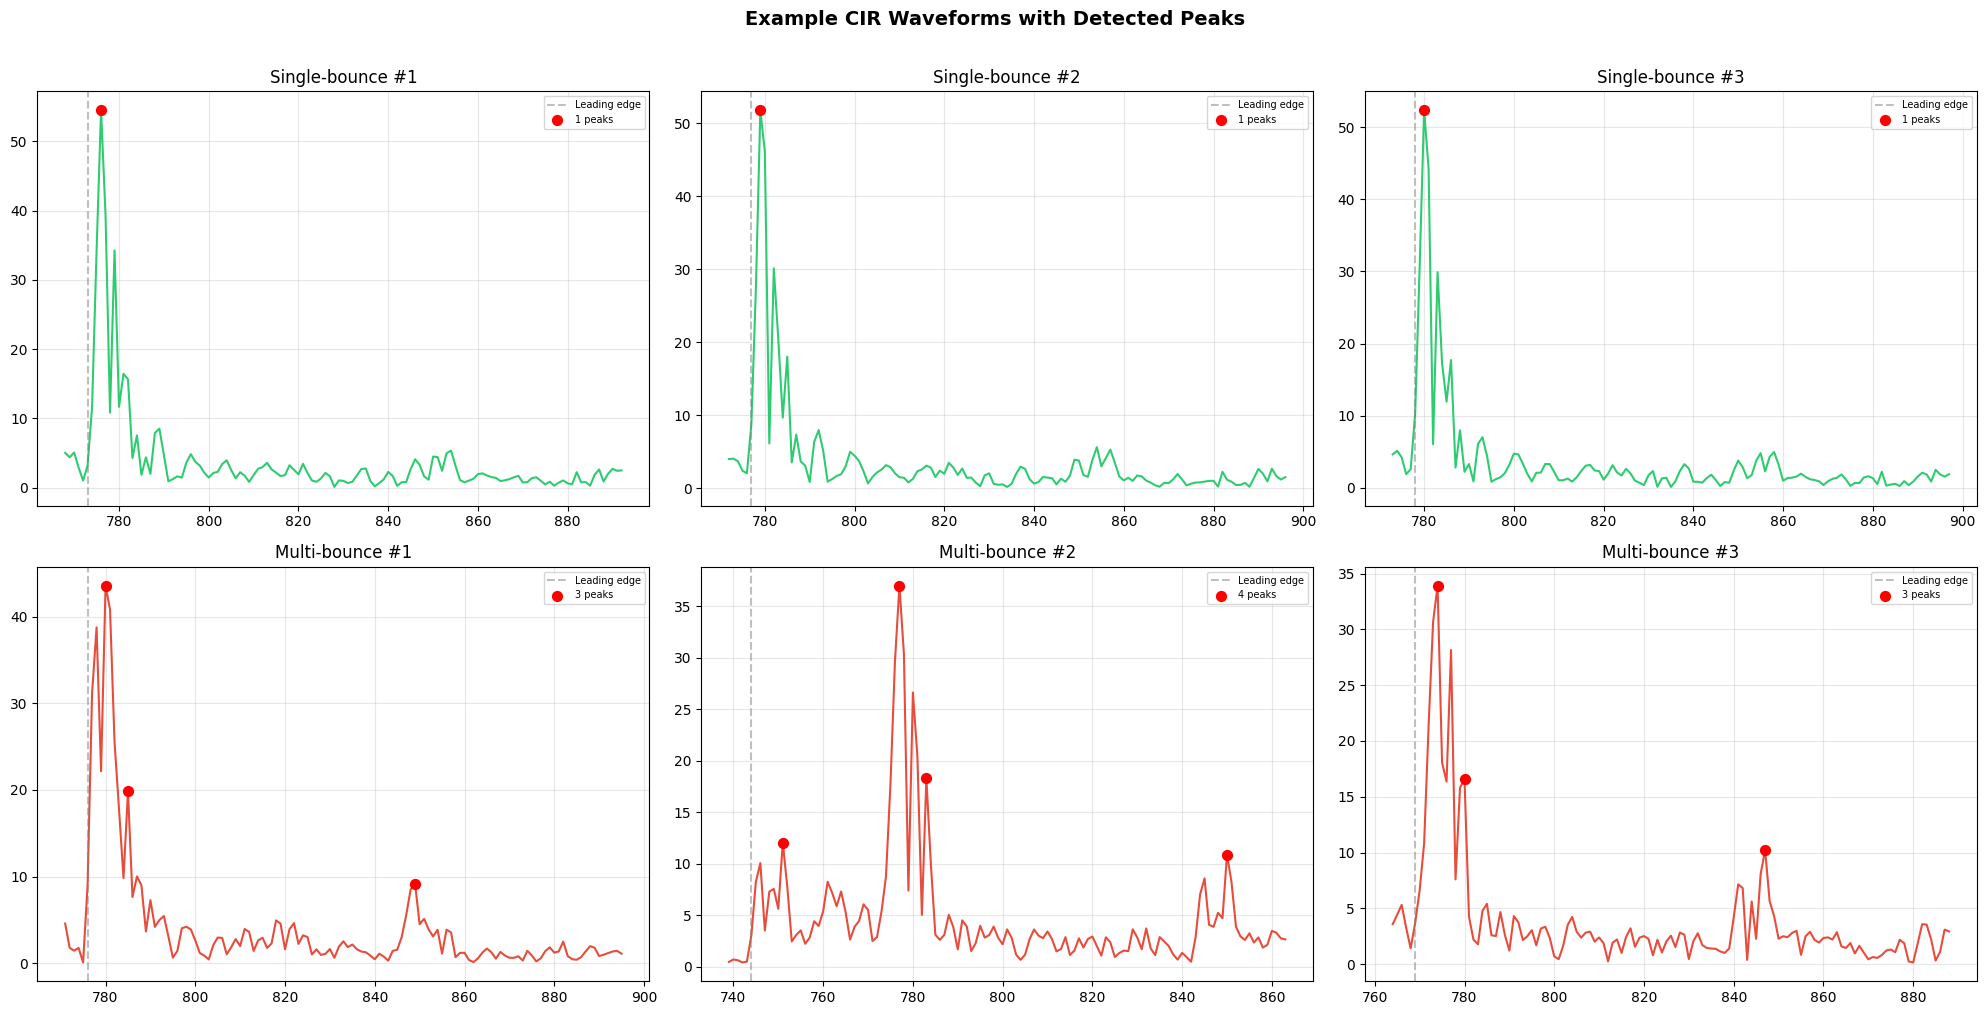

In [6]:
# ==========================================
# EXAMPLE CIR WAVEFORMS
# ==========================================
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

single_idx = np.where(single_mask)[0]
multi_idx = np.where(multi_mask)[0]

# Show 3 single-bounce examples
for col in range(3):
    if col < len(single_idx):
        idx = single_idx[col]
        sig = raw_sigs[idx]
        le = leading_edges[idx]
        
        roi_start = max(0, le - 5)
        roi_end = min(len(sig), le + 120)
        x_range = np.arange(roi_start, roi_end)
        
        ax = axs[0, col]
        ax.plot(x_range, sig[roi_start:roi_end], color='#2ecc71', lw=1.5)
        ax.axvline(le, color='gray', ls='--', alpha=0.5, label='Leading edge')
        
        # Mark peaks
        roi = sig[roi_start:roi_end]
        if np.max(roi) > 0:
            roi_norm = roi / np.max(roi)
            peaks, _ = find_peaks(roi_norm, prominence=CONFIG["peak_prominence"],
                                  distance=CONFIG["peak_min_distance"])
            ax.scatter(x_range[peaks], sig[roi_start:roi_end][peaks],
                       color='red', s=50, zorder=5, label=f'{len(peaks)} peaks')
        
        ax.set_title(f"Single-bounce #{col+1}")
        ax.legend(fontsize=7)
        ax.grid(True, alpha=0.3)

# Show 3 multi-bounce examples
for col in range(3):
    if col < len(multi_idx):
        idx = multi_idx[col]
        sig = raw_sigs[idx]
        le = leading_edges[idx]
        
        roi_start = max(0, le - 5)
        roi_end = min(len(sig), le + 120)
        x_range = np.arange(roi_start, roi_end)
        
        ax = axs[1, col]
        ax.plot(x_range, sig[roi_start:roi_end], color='#e74c3c', lw=1.5)
        ax.axvline(le, color='gray', ls='--', alpha=0.5, label='Leading edge')
        
        roi = sig[roi_start:roi_end]
        if np.max(roi) > 0:
            roi_norm = roi / np.max(roi)
            peaks, _ = find_peaks(roi_norm, prominence=CONFIG["peak_prominence"],
                                  distance=CONFIG["peak_min_distance"])
            ax.scatter(x_range[peaks], sig[roi_start:roi_end][peaks],
                       color='red', s=50, zorder=5, label=f'{len(peaks)} peaks')
        
        ax.set_title(f"Multi-bounce #{col+1}")
        ax.legend(fontsize=7)
        ax.grid(True, alpha=0.3)

plt.suptitle("Example CIR Waveforms with Detected Peaks",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## Section 4b: Feature Explainability — Annotated CIR Waveform

Visualize **what each feature physically measures** on the CIR waveform.
This makes the model interpretable: every feature maps to a measurable property of the signal.

| Feature | Annotation on CIR |
|---------|-------------------|
| **Rise Time** | Horizontal arrow from leading edge to peak |
| **Kurtosis** | Shaded window around peak (shape sharpness) |
| **RMS Delay Spread** | PDP temporal spread (energy distribution) |
| **Mean Excess Delay** | Mean delay marker on PDP |
| **Power Ratio** | First-path energy window vs total |

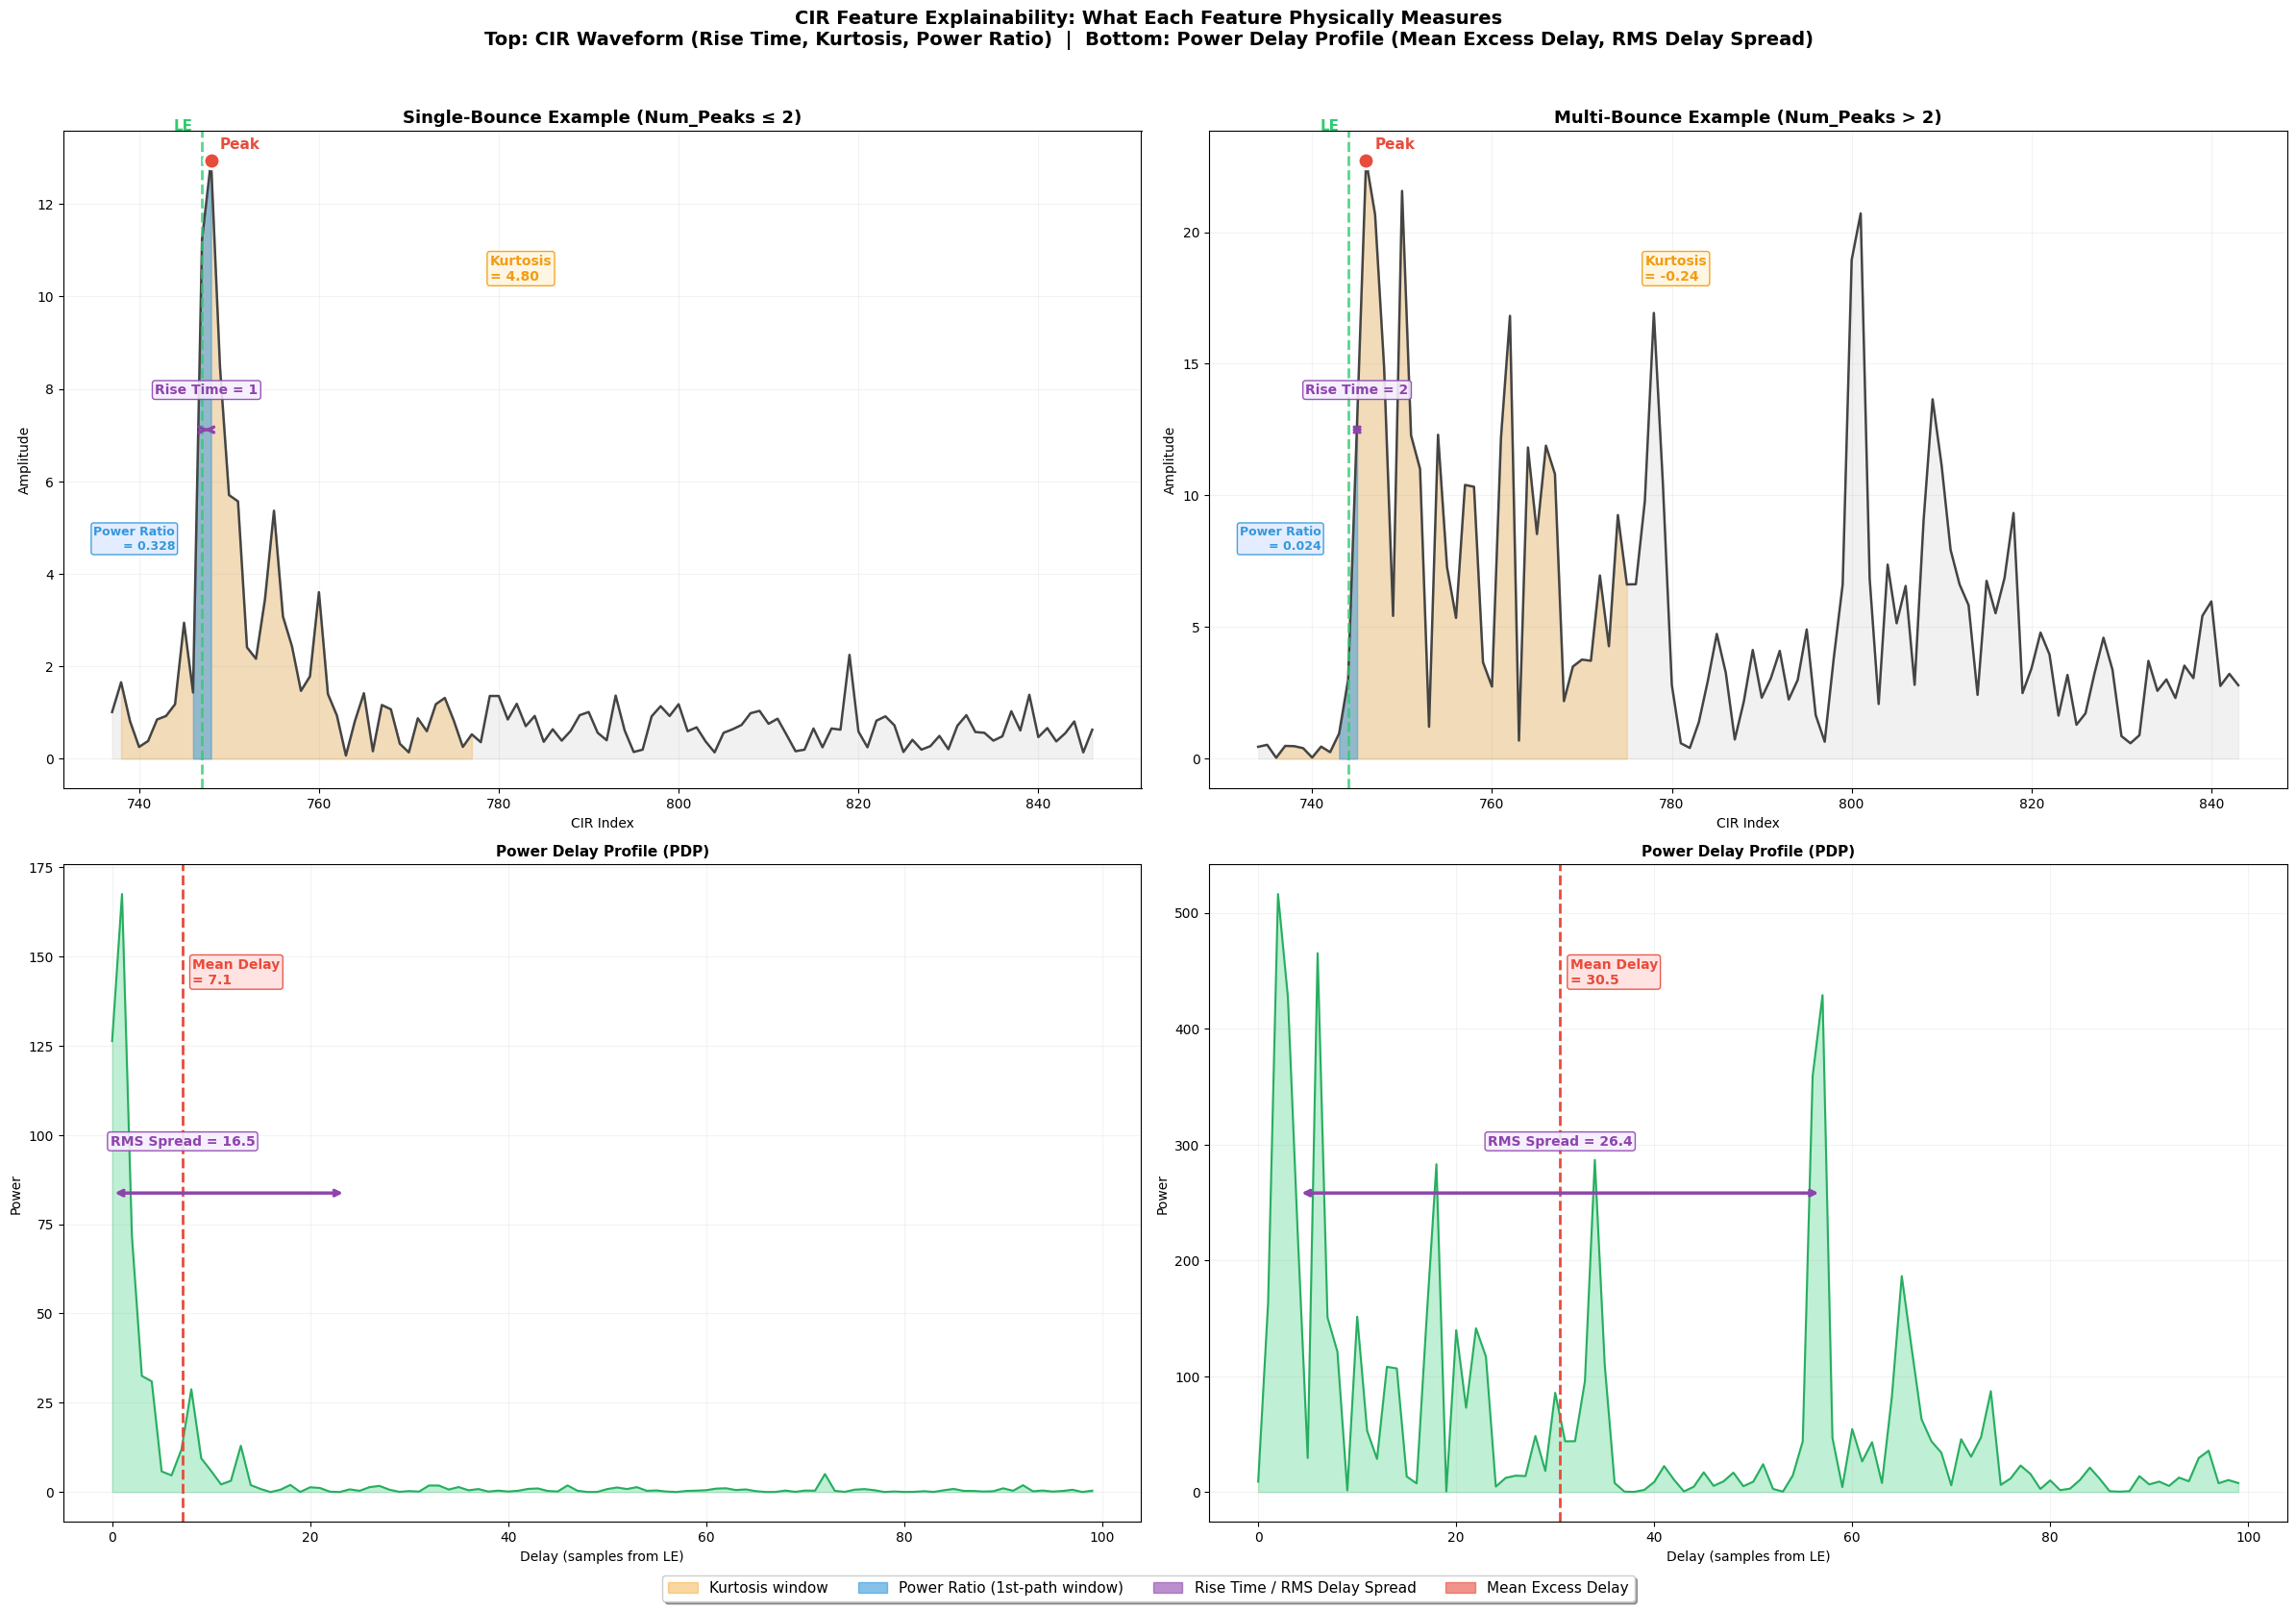


Feature Comparison (Single vs Multi bounce):
Feature                   |   Single-Bounce |    Multi-Bounce
------------------------------------------------------------
Kurtosis                  |           4.802 |          -0.244
Rise_Time                 |           1.000 |           2.000
RMS_Delay_Spread          |          24.118 |          34.671
Mean_Excess_Delay         |           9.894 |          36.126
Power_Ratio               |           0.328 |           0.024


In [7]:
# ==========================================
# ANNOTATED CIR WAVEFORM — FEATURE EXPLAINABILITY
# ==========================================
# Show what each of the 5 features physically measures on the CIR.
# Left: Single-bounce example | Right: Multi-bounce example

import matplotlib.patches as mpatches

def plot_annotated_cir(sig, leading_edge, label_text, ax_cir, ax_pdp, config=CONFIG):
    """Plot a CIR waveform with all 5 features annotated."""
    search_start = config["search_start"]
    search_end = config["search_end"]

    peak_idx = np.argmax(sig[search_start:search_end]) + search_start
    peak_val = sig[peak_idx]

    # Plot region
    plot_start = max(0, leading_edge - 10)
    plot_end = min(len(sig), leading_edge + 100)
    x_idx = np.arange(plot_start, plot_end)
    y_vals = sig[plot_start:plot_end]

    # === TOP: CIR Waveform ===
    ax_cir.plot(x_idx, y_vals, color='#444', lw=1.8)
    ax_cir.fill_between(x_idx, 0, y_vals, color='#ddd', alpha=0.4)

    # 1. LEADING EDGE marker
    ax_cir.axvline(leading_edge, color='#2ecc71', ls='--', lw=2, alpha=0.8)
    ax_cir.text(leading_edge - 1, peak_val * 1.05, 'LE',
                fontsize=11, fontweight='bold', color='#2ecc71', ha='right')

    # 2. PEAK marker
    ax_cir.plot(peak_idx, peak_val, 'o', color='#e74c3c', markersize=12,
                markeredgecolor='white', markeredgewidth=2, zorder=10)
    ax_cir.text(peak_idx + 1, peak_val * 1.02, 'Peak',
                fontsize=11, fontweight='bold', color='#e74c3c')

    # 3. RISE TIME — arrow from LE to peak
    rise_time = peak_idx - leading_edge
    mid_y = peak_val * 0.55
    ax_cir.annotate('', xy=(peak_idx, mid_y), xytext=(leading_edge, mid_y),
                     arrowprops=dict(arrowstyle='<->', color='#8e44ad', lw=2.5))
    ax_cir.text((leading_edge + peak_idx) / 2, mid_y + peak_val * 0.06,
                f'Rise Time = {rise_time}',
                ha='center', fontsize=10, fontweight='bold', color='#8e44ad',
                bbox=dict(facecolor='#f5eeff', edgecolor='#8e44ad',
                          boxstyle='round,pad=0.2', alpha=0.9))

    # 4. KURTOSIS WINDOW — shaded region around peak
    kurt_start = max(plot_start, peak_idx - 10)
    kurt_end = min(plot_end, peak_idx + 30)
    kurt_x = np.arange(kurt_start, kurt_end)
    kurt_y = sig[kurt_start:kurt_end]
    ax_cir.fill_between(kurt_x, 0, kurt_y, color='#f39c12', alpha=0.25)

    # Compute kurtosis value
    window = sig[kurt_start:kurt_end]
    kurt_val = scipy_kurtosis(window, fisher=True) if len(window) > 4 else 0.0
    ax_cir.text(kurt_end + 1, peak_val * 0.8,
                f'Kurtosis\n= {kurt_val:.2f}',
                fontsize=10, fontweight='bold', color='#f39c12',
                bbox=dict(facecolor='#fef5e0', edgecolor='#f39c12',
                          boxstyle='round,pad=0.2', alpha=0.9))

    # 5. POWER RATIO — first-path window
    fp_start = max(plot_start, leading_edge - 1)
    fp_end = min(plot_end, leading_edge + 2)
    fp_x = np.arange(fp_start, fp_end)
    fp_y = sig[fp_start:fp_end]
    ax_cir.fill_between(fp_x, 0, fp_y, color='#3498db', alpha=0.5)

    fp_energy = np.sum(sig[fp_start:fp_end] ** 2)
    total_energy = np.sum(sig ** 2)
    power_ratio = fp_energy / total_energy if total_energy > 0 else 0.0
    ax_cir.text(fp_start - 2, peak_val * 0.35,
                f'Power Ratio\n= {power_ratio:.3f}',
                fontsize=9, fontweight='bold', color='#3498db', ha='right',
                bbox=dict(facecolor='#e0ecff', edgecolor='#3498db',
                          boxstyle='round,pad=0.2', alpha=0.9))

    ax_cir.set_title(label_text, fontsize=13, fontweight='bold')
    ax_cir.set_xlabel("CIR Index")
    ax_cir.set_ylabel("Amplitude")
    ax_cir.grid(True, alpha=0.15)

    # === BOTTOM: Power Delay Profile (PDP) ===
    pdp_start = max(0, leading_edge)
    pdp_len = 100
    pdp_sig = sig[pdp_start:min(pdp_start + pdp_len, len(sig))]
    pdp = pdp_sig ** 2
    total_pdp = np.sum(pdp)
    times = np.arange(len(pdp))

    ax_pdp.fill_between(times, 0, pdp, color='#2ecc71', alpha=0.3)
    ax_pdp.plot(times, pdp, color='#27ae60', lw=1.5)

    if total_pdp > 0:
        mean_delay = np.sum(pdp * times) / total_pdp
        second_moment = np.sum(pdp * times ** 2) / total_pdp
        rms_spread = np.sqrt(max(0, second_moment - mean_delay ** 2))

        # 6. MEAN EXCESS DELAY — vertical line
        ax_pdp.axvline(mean_delay, color='#e74c3c', ls='--', lw=2)
        ax_pdp.text(mean_delay + 1, np.max(pdp) * 0.85,
                    f'Mean Delay\n= {mean_delay:.1f}',
                    fontsize=10, fontweight='bold', color='#e74c3c',
                    bbox=dict(facecolor='#ffe0e0', edgecolor='#e74c3c',
                              boxstyle='round,pad=0.2', alpha=0.9))

        # 7. RMS DELAY SPREAD — bracket showing +/-1 std
        left = max(0, mean_delay - rms_spread)
        right = min(len(pdp) - 1, mean_delay + rms_spread)
        bracket_y = np.max(pdp) * 0.5
        ax_pdp.annotate('', xy=(right, bracket_y), xytext=(left, bracket_y),
                         arrowprops=dict(arrowstyle='<->', color='#8e44ad', lw=2.5))
        ax_pdp.text(mean_delay, bracket_y + np.max(pdp) * 0.08,
                    f'RMS Spread = {rms_spread:.1f}',
                    ha='center', fontsize=10, fontweight='bold', color='#8e44ad',
                    bbox=dict(facecolor='#f5eeff', edgecolor='#8e44ad',
                              boxstyle='round,pad=0.2', alpha=0.9))

    ax_pdp.set_title("Power Delay Profile (PDP)", fontsize=11, fontweight='bold')
    ax_pdp.set_xlabel("Delay (samples from LE)")
    ax_pdp.set_ylabel("Power")
    ax_pdp.grid(True, alpha=0.15)


# Pick representative samples
single_idx_arr = np.where(bounce_labels == 0)[0]
multi_idx_arr = np.where(bounce_labels == 1)[0]

# Pick median kurtosis sample for each class (representative)
single_kurts = feature_df.iloc[single_idx_arr]["Kurtosis"].values
multi_kurts = feature_df.iloc[multi_idx_arr]["Kurtosis"].values
single_pick = single_idx_arr[np.argsort(single_kurts)[len(single_kurts) // 2]]
multi_pick = multi_idx_arr[np.argsort(multi_kurts)[len(multi_kurts) // 2]]

fig, axs = plt.subplots(2, 2, figsize=(24, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Left: Single-bounce
plot_annotated_cir(
    raw_sigs[single_pick], leading_edges[single_pick],
    f"Single-Bounce Example (Num_Peaks \u2264 {CONFIG['single_bounce_max_peaks']})",
    ax_cir=axs[0, 0], ax_pdp=axs[1, 0]
)

# Right: Multi-bounce
plot_annotated_cir(
    raw_sigs[multi_pick], leading_edges[multi_pick],
    f"Multi-Bounce Example (Num_Peaks > {CONFIG['single_bounce_max_peaks']})",
    ax_cir=axs[0, 1], ax_pdp=axs[1, 1]
)

# Legend
legend_patches = [
    mpatches.Patch(color='#f39c12', alpha=0.4, label='Kurtosis window'),
    mpatches.Patch(color='#3498db', alpha=0.6, label='Power Ratio (1st-path window)'),
    mpatches.Patch(color='#8e44ad', alpha=0.6, label='Rise Time / RMS Delay Spread'),
    mpatches.Patch(color='#e74c3c', alpha=0.6, label='Mean Excess Delay'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4,
           fontsize=11, frameon=True, fancybox=True, shadow=True,
           bbox_to_anchor=(0.5, -0.02))

fig.suptitle(
    "CIR Feature Explainability: What Each Feature Physically Measures\n"
    "Top: CIR Waveform (Rise Time, Kurtosis, Power Ratio)  |  "
    "Bottom: Power Delay Profile (Mean Excess Delay, RMS Delay Spread)",
    fontsize=14, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

# Print feature comparison
print(f"\nFeature Comparison (Single vs Multi bounce):")
print(f"{'Feature':<25} | {'Single-Bounce':>15} | {'Multi-Bounce':>15}")
print(f"{'-'*60}")
s_feats = extract_cir_features(raw_sigs[single_pick], leading_edges[single_pick])
m_feats = extract_cir_features(raw_sigs[multi_pick], leading_edges[multi_pick])
for feat in FEATURE_NAMES:
    print(f"{feat:<25} | {s_feats[feat]:>15.3f} | {m_feats[feat]:>15.3f}")

---
## Section 5: Random Forest Classifier

**Why Random Forest over MLP:**
- Dataset is small (~1800 NLOS samples) — RF handles small data natively without overfitting
- Features are tabular (6 physics features) — RF is the standard for tabular classification
- No learning rate, epochs, or dropout to tune — works well out of the box
- Built-in feature importance — directly interpretable for the report
- Training is instantaneous — aligns with "minimum training" principle

**Parameters**: 200 trees, no max depth, min_samples_split=5, min_samples_leaf=2, class_weight="balanced"

In [8]:
# ==========================================
# RANDOM FOREST TRAINING (70/30 SPLIT)
# ==========================================
X_all = feature_df[FEATURE_NAMES].values
y_all = bounce_labels

# 70/30 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=CONFIG["test_ratio"],
    stratify=y_all,
    random_state=CONFIG["seed"]
)

print(f"Split (70/30):")
print(f"  Train: {len(X_train)} (Single: {int(np.sum(y_train==0))}, Multi: {int(np.sum(y_train==1))})")
print(f"  Test:  {len(X_test)} (Single: {int(np.sum(y_test==0))}, Multi: {int(np.sum(y_test==1))})")

# Train Random Forest (no feature scaling needed — trees are scale-invariant)
rf_model = RandomForestClassifier(
    n_estimators=CONFIG["n_estimators"],
    max_depth=CONFIG["max_depth"],
    min_samples_split=CONFIG["min_samples_split"],
    min_samples_leaf=CONFIG["min_samples_leaf"],
    class_weight="balanced",
    random_state=CONFIG["seed"],
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

# Evaluate
train_acc = rf_model.score(X_train, y_train)
test_acc = rf_model.score(X_test, y_test)
print(f"\nTrain Accuracy: {100*train_acc:.2f}%")
print(f"Test Accuracy:  {100*test_acc:.2f}%")

Split (70/30):
  Train: 1260 (Single: 596, Multi: 664)
  Test:  540 (Single: 255, Multi: 285)

Train Accuracy: 98.49%
Test Accuracy:  94.07%


---
## Section 6: Diagnostics

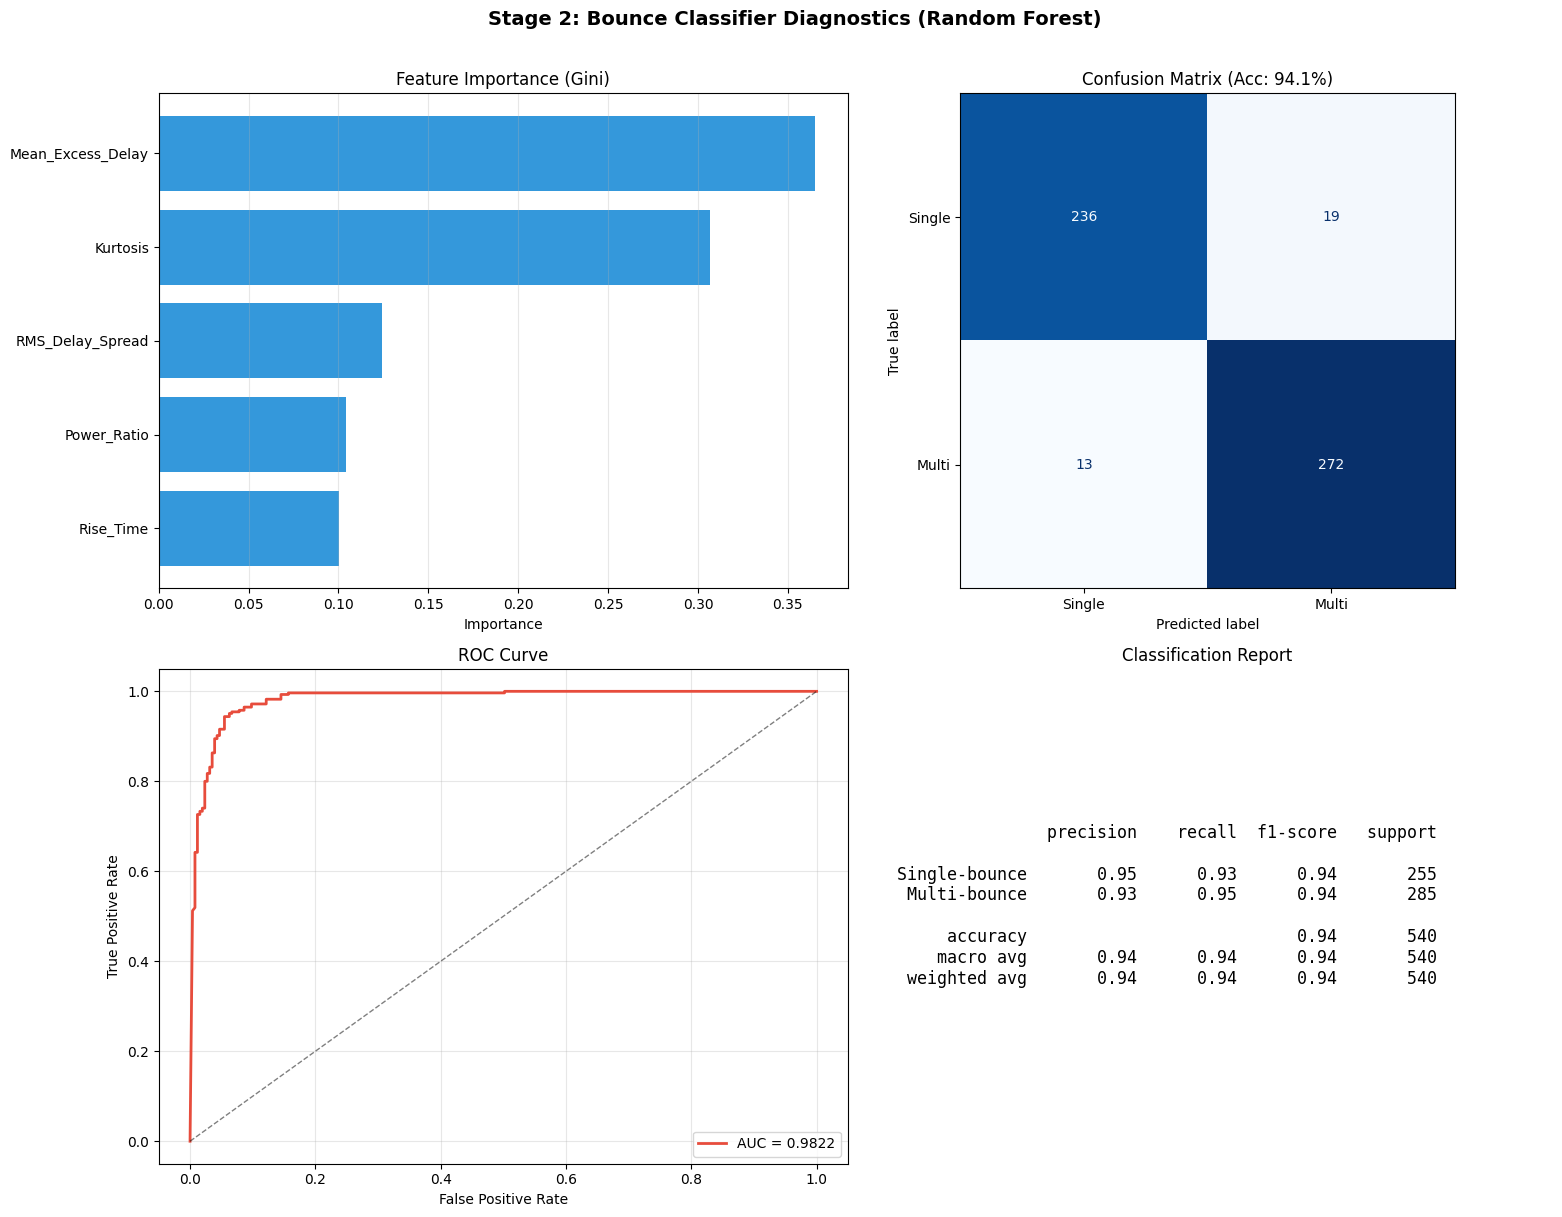


Feature Importance (ranked):
  Mean_Excess_Delay         0.3651
  Kurtosis                  0.3064
  RMS_Delay_Spread          0.1241
  Power_Ratio               0.1041
  Rise_Time                 0.1003


In [9]:
# ==========================================
# DIAGNOSTICS
# ==========================================
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# 1. Feature Importance
ax = axs[0, 0]
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)
ax.barh(np.array(FEATURE_NAMES)[sorted_idx], importances[sorted_idx], color='#3498db')
ax.set_title("Feature Importance (Gini)")
ax.set_xlabel("Importance")
ax.grid(True, alpha=0.3, axis='x')

# 2. Confusion Matrix
ax = axs[0, 1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Single', 'Multi'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
acc = (y_test == y_pred).mean()
ax.set_title(f"Confusion Matrix (Acc: {100*acc:.1f}%)")

# 3. ROC Curve
ax = axs[1, 0]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'AUC = {roc_auc:.4f}')
ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
ax.set_title("ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# 4. Classification Report
ax = axs[1, 1]
report = classification_report(y_test, y_pred, target_names=['Single-bounce', 'Multi-bounce'])
ax.text(0.05, 0.5, report, fontsize=12, fontfamily='monospace',
        verticalalignment='center', transform=ax.transAxes)
ax.set_title("Classification Report")
ax.axis('off')

plt.suptitle("Stage 2: Bounce Classifier Diagnostics (Random Forest)",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\nFeature Importance (ranked):")
for feat, imp in sorted(zip(FEATURE_NAMES, importances), key=lambda x: -x[1]):
    print(f"  {feat:<25} {imp:.4f}")

---
## Section 7: Save Artifacts

In [10]:
# ==========================================
# SAVE ARTIFACTS
# ==========================================
joblib.dump(rf_model, "stage2_bounce_rf.joblib")
print("Saved: stage2_bounce_rf.joblib")

joblib.dump({
    "config": CONFIG,
    "feature_names": FEATURE_NAMES,
}, "stage2_config.joblib")
print("Saved: stage2_config.joblib")

print(f"\nArtifacts ready for Stage 3 pipeline.")

Saved: stage2_bounce_rf.joblib
Saved: stage2_config.joblib

Artifacts ready for Stage 3 pipeline.


In [11]:
print("Stage 2 complete.")
print("Model artifact: stage2_bounce_rf.joblib")
print("Config artifact: stage2_config.joblib")
print("\nPipeline: Stage 1 (LNN) -> Stage 2 (RF) -> Ready for Stage 3.")

Stage 2 complete.
Model artifact: stage2_bounce_rf.joblib
Config artifact: stage2_config.joblib

Pipeline: Stage 1 (LNN) -> Stage 2 (RF) -> Ready for Stage 3.
